# Install Transformers Library

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# !pip install transformers
!pip install transformers==2.5.1

     |████████████████████████████████| 501kB 10.5MB/s 
     |████████████████████████████████| 133kB 24.9MB/s 
     |████████████████████████████████| 890kB 13.2MB/s 
     |████████████████████████████████| 1.1MB 46.5MB/s 
     |████████████████████████████████| 3.7MB 21.3MB/s 
     |████████████████████████████████| 7.1MB 51.1MB/s 
     |████████████████████████████████| 71kB 5.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=038fc8684fe177c874a260e9307290b8741368b4917ec58cc483c43e36b3aaaf
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
ERROR: botocore 1.19.39 has requirement urllib3<1.27,>=1.25.4; python_version != "3.4", but you'll have urllib3 1.24.3 which is incompatible.


In [24]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [25]:
df1= pd.read_csv("/content/drive/MyDrive/IIITD Data/ML/Intent Detection/para_df.tsv", sep="\t")
df3= pd.read_csv("/content/drive/MyDrive/IIITD Data/ML/Intent Detection/atis_intents_train.csv", names=['intent', 'dialog'])

In [26]:
df1.head()

,intent,dialog
0,atis_flight,show delta airlines flights from jfk to miami
1,atis_airfare,What is the cost of a one day trip from Detroi...
2,atis_flight,list flights from phoenix arizona to ontario ...
3,atis_flight,i would like to leave thursday morning from i...
4,atis_flight,show flights from minneapolis to kansas city


In [27]:
flag = 0
df3.head()

,intent,dialog
0,atis_flight,i want to fly from boston at 838 am and arriv...
1,atis_flight,what flights are available from pittsburgh to...
2,atis_flight_time,what is the arrival time in san francisco for...
3,atis_airfare,cheapest airfare from tacoma to orlando
4,atis_airfare,round trip fares from pittsburgh to philadelp...


atis_flight_time intent has been dropped due to its frequency less than 9
atis_flight_time intent has been dropped due to its frequency less than 9
atis_quantity intent has been dropped due to its frequency less than 9
atis_aircraft intent has been dropped due to its frequency less than 9


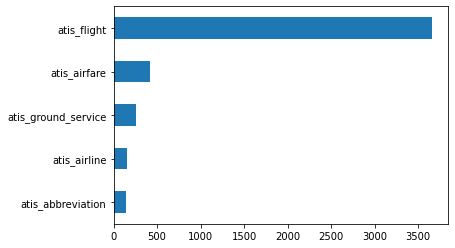

In [28]:
# drop rows with very very less number of intents (<=9)
drop_intents = ["atis_flight_time", "atis_flight_time", "atis_quantity", "atis_aircraft"]
for x in drop_intents:
    if flag==1:
        print("intents have already been dropped. Proceed ahead")
        break
    drop_dialog = df3[df3['intent']==x].index
    df3 = df3.drop(drop_dialog)
    print(f"{x} intent has been dropped due to its frequency less than 9")
flag=1
df3['intent'].value_counts().plot(kind='barh').invert_yaxis()

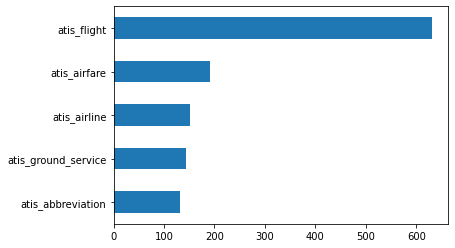

In [29]:
# drop_dialog = df1[df1['intent']=='intent'].index
# df1 = df1.drop(drop_dialog)
# df1['intent'].value_counts()

df1['intent'].value_counts().plot(kind='barh').invert_yaxis()

In [30]:
def partition(x):
    if x == "atis_flight": return 0
    elif x == "atis_airfare": return 2
    elif x == "atis_airline": return 3
    elif x == "atis_ground_service": return 4
    elif x == "atis_abbreviation": return 1
    
df1['intent'] = df1['intent'].apply(partition)
df3['intent'] = df3['intent'].apply(partition)
df1.head()

,intent,dialog
0,0,show delta airlines flights from jfk to miami
1,2,What is the cost of a one day trip from Detroi...
2,0,list flights from phoenix arizona to ontario ...
3,0,i would like to leave thursday morning from i...
4,0,show flights from minneapolis to kansas city


# Load Dataset

In [31]:
df = df1

In [32]:
df.shape

(1252, 2)

In [33]:
# check class distribution
df['intent'].value_counts(normalize = True)

0    0.504792
2    0.153355
3    0.121406
4    0.115016
1    0.105431
Name: intent, dtype: float64

In [34]:
df3['intent'].value_counts(normalize = True)

0    0.788726
2    0.091007
4    0.054862
3    0.033778
1    0.031627
Name: intent, dtype: float64

# Split train dataset into train, validation and test sets

In [35]:
train_text, train_labels= df1['dialog'], df1['intent']
val_text, val_labels= df3['dialog'], df3['intent']

# Import BERT Model and BERT Tokenizer

In [36]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [37]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

# Tokenization

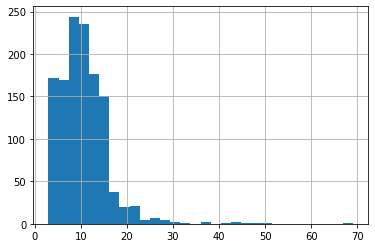

In [38]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [39]:
np.array(seq_len).mean()

10.585463258785943

In [40]:
max_seq_len = 11

In [41]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# # tokenize and encode sequences in the test set
# tokens_test = tokenizer.batch_encode_plus(
#     test_text.tolist(),
#     max_length = max_seq_len,
#     pad_to_max_length=True,
#     truncation=True,
#     return_token_type_ids=False
# )

# Convert Integer Sequences to Tensors

In [42]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
# test_seq = torch.tensor(tokens_test['input_ids'])
# test_mask = torch.tensor(tokens_test['attention_mask'])
# test_y = torch.tensor(test_labels.tolist())

# Create DataLoaders

In [43]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Freeze BERT Parameters

In [44]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

# Define Model Architecture

In [45]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,5)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):
      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      
    #   print(sent_id, mask)
    #   print(type(cls_hs))
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [46]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [47]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

# Find Class Weights

In [48]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print(class_wts)

[0.39620253 1.8969697  1.30416667 1.64736842 1.73888889]


In [49]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 30

# Fine-Tune BERT

In [50]:
# function to train the model
def train():
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward() # dl/dw

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step() #  w = w_prev - n (dw/dl)

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [51]:
# function for evaluating the model
def evaluate():
  print("\nEvaluating...")
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
    #   elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      # model predictions
      preds = model(sent_id, mask)
      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)
  return avg_loss, total_preds

# Start Model Training

In [52]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 30


/usr/local/lib/python3.6/dist-packages/transformers/optimization.py:155: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)



Evaluating...
  Batch    50  of    146.
  Batch   100  of    146.

Training Loss: 1.554
Validation Loss: 1.720

 Epoch 2 / 30

Evaluating...
  Batch    50  of    146.
  Batch   100  of    146.

Training Loss: 1.285
Validation Loss: 1.291

 Epoch 3 / 30

Evaluating...
  Batch    50  of    146.
  Batch   100  of    146.

Training Loss: 1.222
Validation Loss: 1.081

 Epoch 4 / 30

Evaluating...
  Batch    50  of    146.
  Batch   100  of    146.

Training Loss: 1.127
Validation Loss: 1.066

 Epoch 5 / 30

Evaluating...
  Batch    50  of    146.
  Batch   100  of    146.

Training Loss: 1.061
Validation Loss: 1.073

 Epoch 6 / 30

Evaluating...
  Batch    50  of    146.
  Batch   100  of    146.

Training Loss: 1.009
Validation Loss: 1.096

 Epoch 7 / 30

Evaluating...
  Batch    50  of    146.
  Batch   100  of    146.

Training Loss: 0.918
Validation Loss: 0.931

 Epoch 8 / 30

Evaluating...
  Batch    50  of    146.
  Batch   100  of    146.

Training Loss: 0.869
Validation Loss: 0.845

# Load Saved Model

In [53]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

# Get Predictions for Test Data

In [54]:
# get predictions for test data
with torch.no_grad():
  preds = model(val_seq.to(device), val_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [55]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(val_y, preds))

              precision    recall  f1-score   support

           0       0.94      0.91      0.93      3666
           1       0.97      0.83      0.89       147
           2       0.53      0.82      0.65       423
           3       0.54      0.46      0.50       157
           4       0.83      0.67      0.74       255

    accuracy                           0.87      4648
   macro avg       0.76      0.74      0.74      4648
weighted avg       0.89      0.87      0.87      4648



In [56]:
# get predictions for train data
with torch.no_grad():
  preds = model(train_seq.to(device), train_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [57]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(train_y, preds))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       632
           1       0.98      0.95      0.96       132
           2       0.81      0.89      0.85       192
           3       0.92      0.79      0.85       152
           4       0.94      0.71      0.81       144

    accuracy                           0.90      1252
   macro avg       0.91      0.86      0.88      1252
weighted avg       0.90      0.90      0.90      1252



In [ ]:
import datetime

x = datetime.datetime.now()
print(str(x.strftime("%H%M%S")))

pd.DataFrame(preds, columns=['label']).to_csv('ans'+str(x.strftime("%H%M%S"))+'.csv', index=None)

075030


--------------------------

Voting of Classes (to be done at the last after running the above code 5 times)

In [ ]:
ans1 = pd.read_csv('/content/ans202137.csv')
ans1 = np.array(ans1['label'])
ans2 = pd.read_csv('/content/ans203152.csv')
ans2 = np.array(ans2['label'])
ans3 = pd.read_csv('/content/ans203649.csv')
ans3 = np.array(ans3['label'])
ans4 = pd.read_csv('/content/ans203952.csv')
ans4 = np.array(ans4['label'])
ans5 = pd.read_csv('/content/ans204153.csv')
ans5 = np.array(ans5['label'])

In [ ]:
ans = pd.DataFrame()
ans["1"] = ans1
ans["2"] = ans2
ans["3"] = ans3
ans["4"] = ans4
ans["5"] = ans5
ans["sum"] = ans["1"] +ans["2"] +ans["3"] +ans["4"] +ans["5"]
def vote(x):
    if x>=3:
        return 1
    return 0
ans["vote"] = ans['sum'].apply(vote)
ans.head()

In [ ]:
print(classification_report(val_y, ans['vote']))